In [1]:
%load_ext autoreload
%load_ext line_profiler

In [2]:
import sys
sys.path.append('../../') #takes us to the directory named foreground_functions that housed the foreground_function.py 
#and the w3j.npy files

#------packages-------------------
%pylab inline
import time
import healpy as hp
import matplotlib.pyplot as plt
import foreground_functions as ff
from scipy.optimize import curve_fit, minimize
import emcee
import corner

Populating the interactive namespace from numpy and matplotlib


# Foreground parameters

In [70]:
#the parameters chosen here (except gamma) are from the BICEP 2018 paper. The alphas differ by addition of 2, as we've
#calculated the C_ells, while the BICEP paper models the D_ells. The amplitudes also have had to be scaled to pivot
#frequency of 95 GHz so differ by a factor (95/original pivot)^beta
A_s_BICEP = 1.0 #micro K^2
A_d_BICEP = 4.6 #micro K^2
alpha_s_BICEP = -0.6
alpha_d_BICEP = -0.4


alpha_s = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_s = -3.1
gamma_s = 0 #-2.6 is the SO value for this
A_s = A_s_BICEP * (ff.scale_synch(95e9, beta_s)/ff.scale_synch(23e9, beta_s))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_s = A_s[0] #make it stop being an array

alpha_d = alpha_s_BICEP - 2 #convert from D_ells to C_ells (ish)
beta_d = 1.6
gamma_d = 0 #-3.5
A_d = A_d_BICEP * (ff.scale_synch(95e9, beta_d)/ff.scale_synch(353e9, beta_d))**2 * 2*pi/(80*81) # scale to new frequency and convert from D_ells to C_ells
A_d = A_d[0] #make it stop being an array



params_s = [A_s, alpha_s, beta_s, gamma_s]
params_d = [A_d, alpha_d, beta_d, gamma_d] 
params_fg = params_s + params_d

nside=128
ells = np.arange(384)
freqs = np.linspace(30,300,10)*1.e9 
SO_freqs = np.array([27, 39, 93, 145, 225, 280])*1e9

# CMB data

In [7]:
#the D_ells of the CMB with r=0.01
camb_lens_r1 = loadtxt('../../power_spectra/camb_lens_r1.dat').T
camb_lens_nobb = loadtxt('../../power_spectra/camb_lens_nobb.dat').T
primo_bb = camb_lens_r1[3]
lens_bb = camb_lens_nobb[3]
r = 0.01
bb_001 = (r * primo_bb + lens_bb)[:384]

In [8]:
def cmb(ells, r):
    return r*primo_bb[:len(ells)] + lens_bb[:len(ells)]

In [9]:
def cosmic_var(model):
    var = np.zeros((len(freqs),len(ells)))
    cosmic_var = 2/(2*ells + 1) * model**2
    return cosmic_var

# define the input model for reference and the associated cosmic variance (do this for my freqs first then we can try with SO stuff)

In [12]:
input_model = ff.auto0x0_fg(ells, freqs, params) + cmb(ells, 0.01)
input_cosmic_var = cosmic_var(input_model)

In [13]:
def chi2_cmb(params, ells, freqs, data):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_d, r = params
    long_params = [A_s, alpha_s, beta_s, 0.0, A_d, alpha_d, beta_d, 0.0]

    chi2=0
    model_made = ff.auto0x0_fg(ells, freqs, long_params) + cmb(ells, r)
    
    chi2 = (data[:,30:] - model_made[:,30:])**2 / input_cosmic_var[:,30:]
    return np.sum(chi2)

# data to be fit

In [27]:
data = ff.const_ps_data_fg(ells, freqs, params) + cmb(ells, 0.01)

# minimise to initialise the MCMC

In [ ]:
initial_cmb = [1.e-7, -3., -2.5, 1.e-7, -3., 2., 1.e-1]

In [20]:
soln = minimize(chi2_cmb, initial_cmb, args=(ells, freqs, signal), method='Powell')
print(soln)

   direc: array([[ 2.65244611e-09, -2.30928254e-03,  4.61549284e-03,
         1.49134718e-09,  2.06039984e-04, -1.31518394e-03,
        -1.41691664e-04],
       [ 4.84824101e-09,  3.23708278e-03,  1.07029507e-02,
        -1.62803096e-09,  4.49006608e-03, -1.62938467e-03,
        -1.04840378e-04],
       [ 1.76615840e-09, -3.49429052e-03,  2.68220481e-03,
         4.23589741e-09,  6.57242690e-04, -3.82181254e-03,
        -1.87507816e-04],
       [-1.66022358e-08, -7.52336816e-02, -1.03554509e-01,
         9.23280271e-09,  1.67257512e-02, -2.12938735e-02,
         3.03045025e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00],
       [ 1.93375212e-09, -1.55534638e-03,  3.22197216e-03,
         7.38605172e-10, -5.76366152e-04, -2.05551361e-04,
        

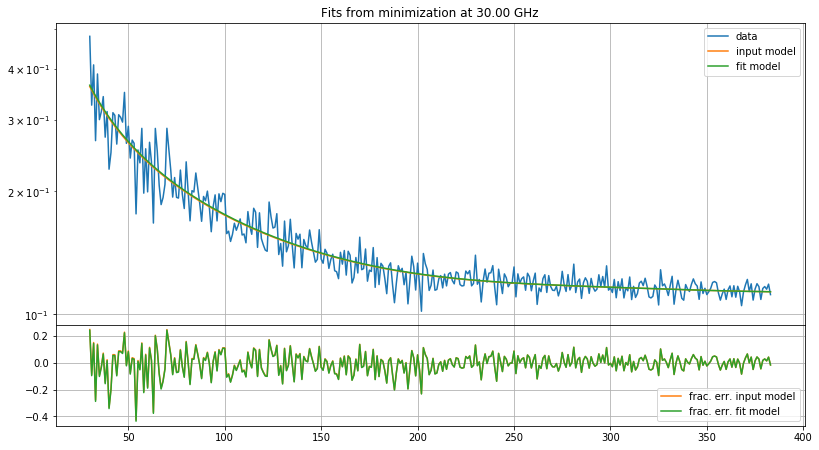

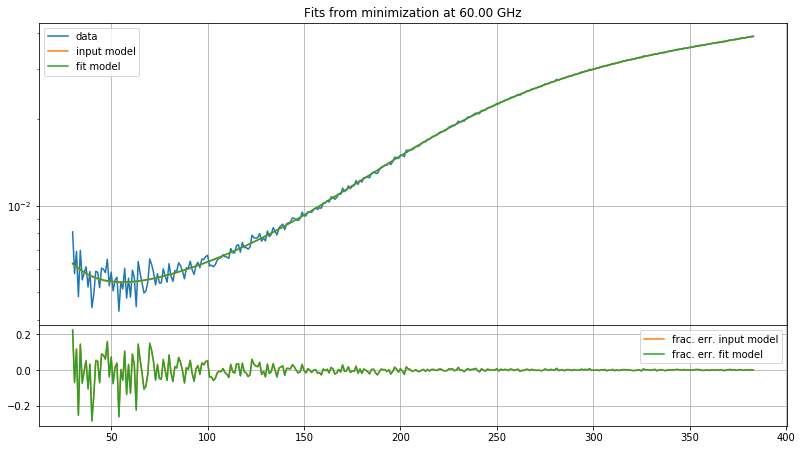

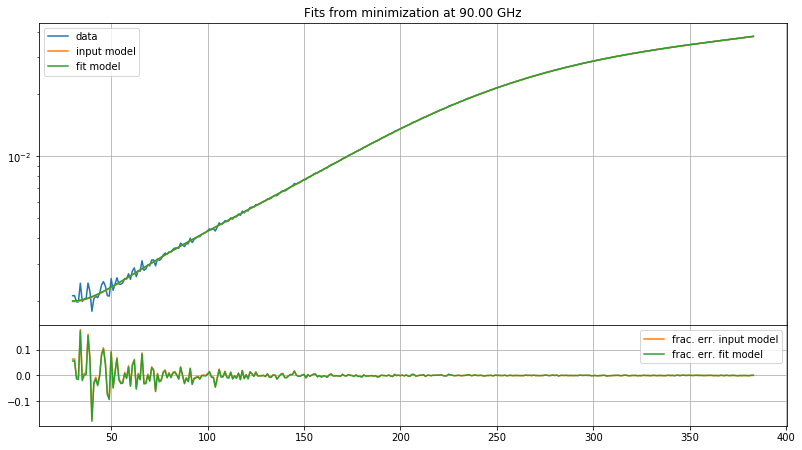

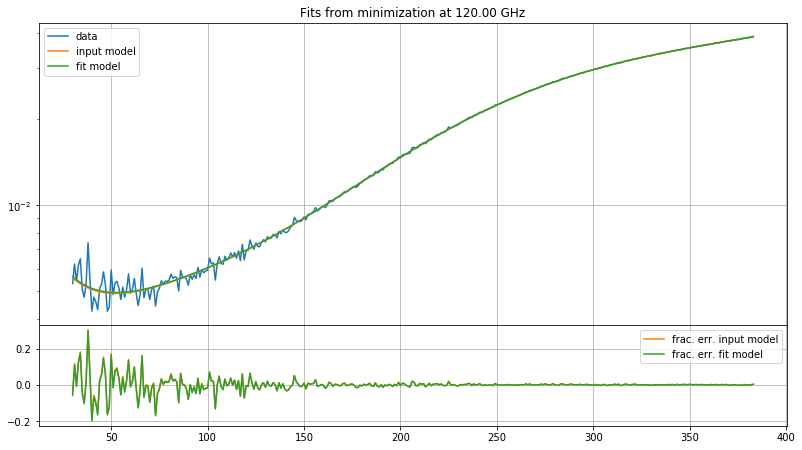

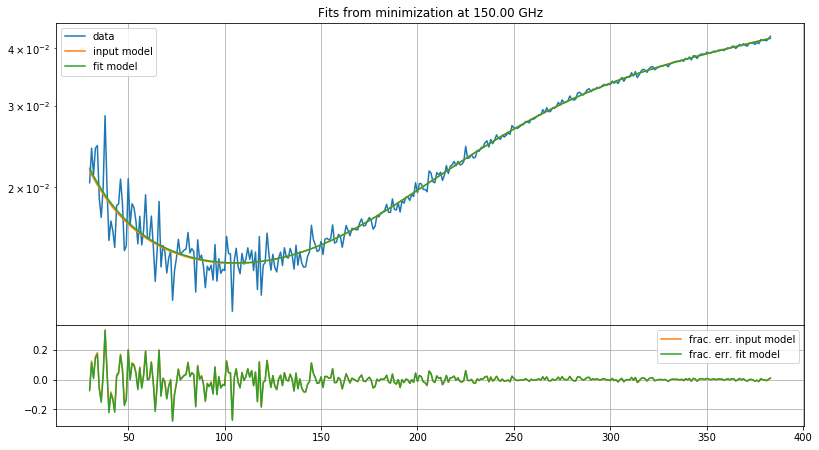

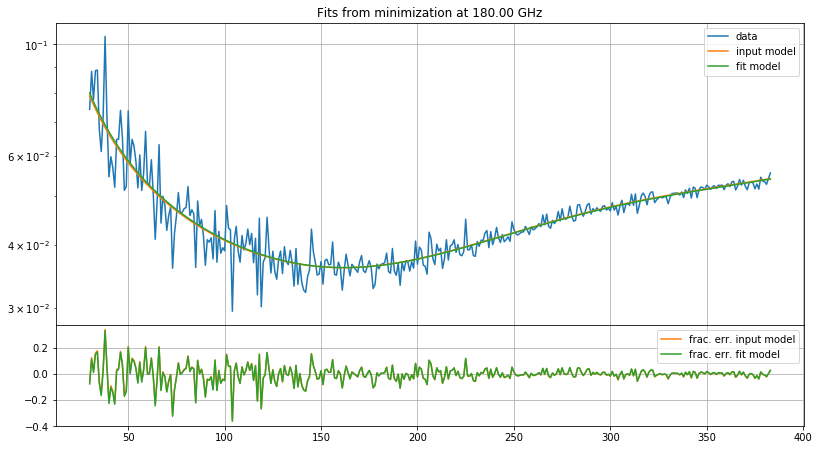

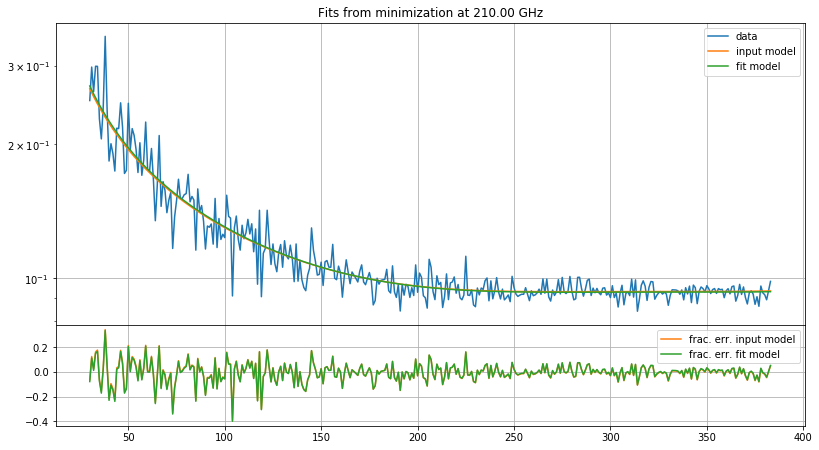

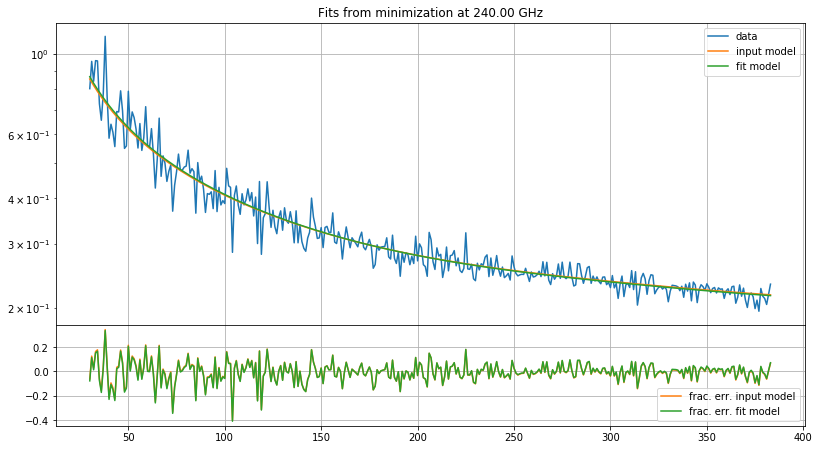

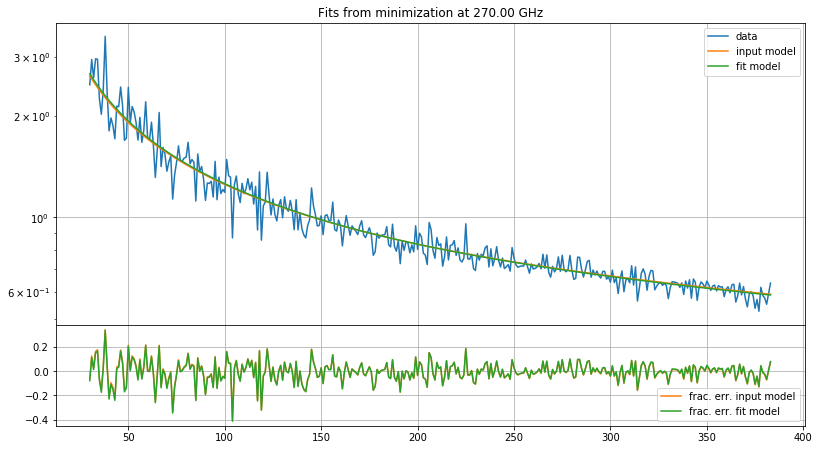

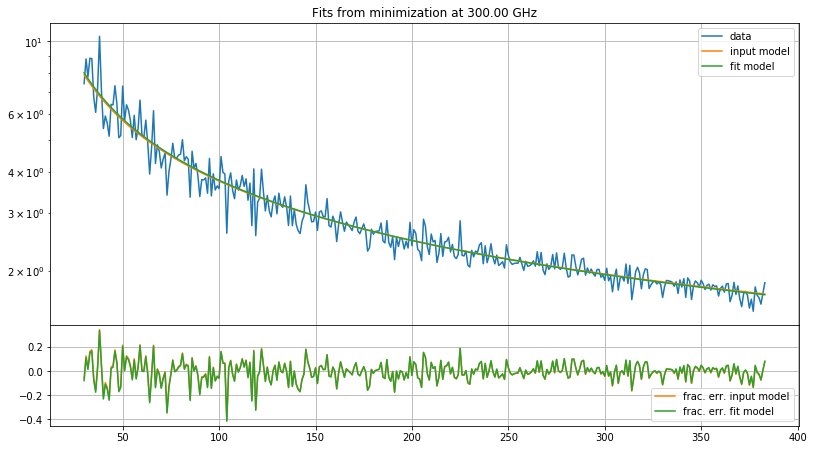

In [71]:
# check the fit and the input against the data
input_model = ff.auto0x0_fg(ells, freqs, params_fg) + cmb(ells, 0.01)
x = soln.x
fit = ff.auto0x0_fg(ells, freqs, [x[0], x[1], x[2], 0, x[3], x[4], x[5], 0]) + cmb(ells, x[-1])

for i in range(len(freqs)):
    fig1 = figure(figsize=(13,7))
    frame1=fig1.add_axes((.1,.3,.8,.6))
    frame1.set_xticklabels([]) #Remove x-tic labels for the first frame
    semilogy(ells[30:], signal[i][30:], label='data')
    semilogy(ells[30:], input_model[i][30:], label='input model', color='C1')
    semilogy(ells[30:], fit[i][30:], label='fit model', color='C2')
    grid()
    title('Fits from minimization at {:.2f} GHz'.format(freqs[i]/1e9))
    legend()
    
    
    frame2=fig1.add_axes((.1,.1,.8,.2)) 
    plot(ells[30:], (signal[i][30:]-input_model[i][30:])/signal[i][30:], color='C1', label='frac. err. input model')
    plot(ells[30:], (signal[i][30:]-fit[i][30:])/signal[i][30:], color='C2', label='frac. err. fit model')
    legend()
    grid()

# priors and probs

In [22]:
#now let's add priors, we'll start with flat priors everywhere
def log_prior(params):
    A_s, alpha_s, beta_s, A_d, alpha_d, beta_s, r = params
    if 0 < A_s and alpha_s < 0 and beta_s < 0 and 0 < A_d and alpha_d < 0 and 0 < beta_d and 0 < r:
        return 0.0
    return -np.inf

In [56]:
def log_prob(params, ells, freqs, data):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp - chi2_cmb(params, ells, freqs, data)

In [69]:
pos = soln.x + 1e-4*np.random.randn(32, 7) #32 walkers in 7 parameter dimensions
nwalkers, ndim = pos.shape
nsteps = 10000
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(ells, freqs, data))
start=time.time()
sampler.run_mcmc(pos, nsteps, progress='notebook');
end = time.time()
serial_time = end - start
print("Serial took {0:.1f} seconds".format(serial_time))


Serial took 9.7 seconds


In [61]:
tau = sampler.get_autocorr_time()
burnin = int(2*np.max(tau))
thin = int(0.5*np.min(tau))
samples = sampler.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = sampler.get_blobs(discard=burnin, flat=True, thin=thin)

ValueError: cannot convert float NaN to integer

In [62]:
sampler.get_chain().shape

(100, 32, 7)

In [63]:
print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))
print("flat log prior shape: {0}".format(log_prior_samples.shape))

NameError: name 'burnin' is not defined

In [66]:
samples.shape

(89600, 7)

IndexError: too many indices for array

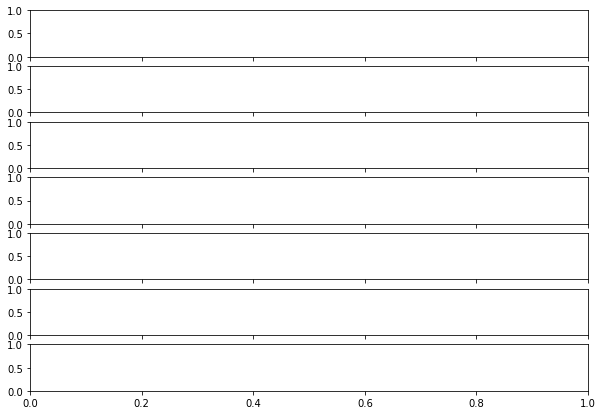

In [68]:
fig, axes = plt.subplots(7, figsize=(10, 7), sharex=True)
labels = [r"$A_s$", r"$\alpha_s$", r"$\beta_s$", r"$A_d$", r"$\alpha_d$", r"$\beta_d$", r"$r$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:,:, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

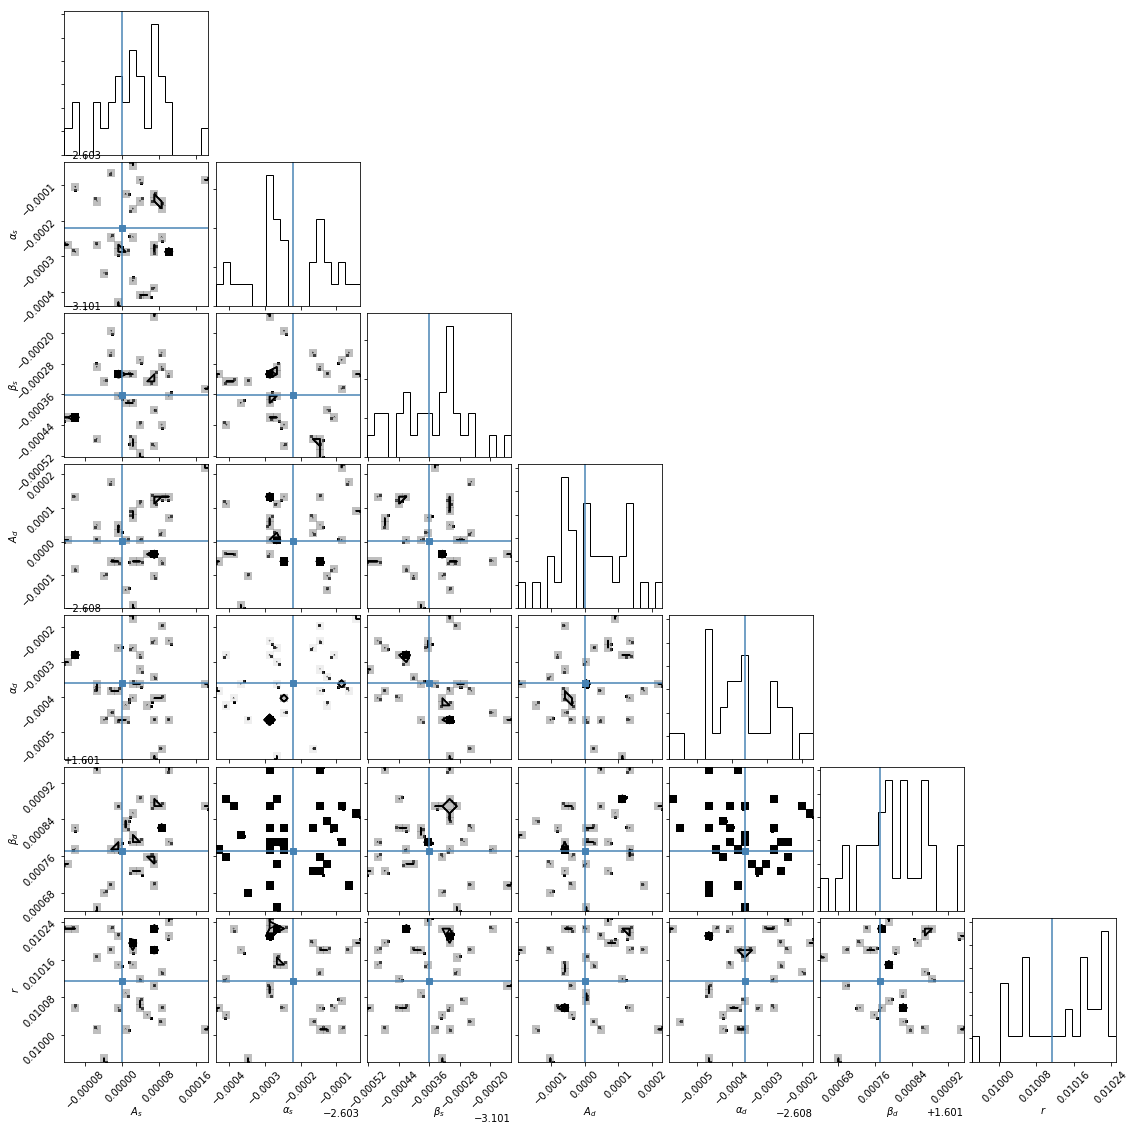

In [42]:
# all_samples = np.concatenate((
#     samples, log_prob_samples[:, None], log_prior_samples[:, None]
# ), axis=1)

# labels += ["log prob", "log prior"]
flat_samples = sampler.get_chain(discard=int(0.3*nsteps), flat=True, thin=25)

corner.corner(flat_samples, labels=labels, truths=soln.x);

(1000000, 32, 7)